<a href="https://colab.research.google.com/github/Iki050901/2106138-Rizki-Saputra-Pratikum-Kecerdasan-buatan/blob/master/TB_Pra_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# TUGAS BESAR PRATIKUM KECERDASAN BUATAN**

# "Prediksi Harga Saham Andro dengan menggunakan LSTM"

dibuat oleh :

*   Ajeng Cita IndahSari (2106073)
*   Rizki Saputra (2106138)



# Membersihkan Data dan melakukan Pre-Processing

## Libarry yang digunakan


In [1]:
pip install tqdm --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Numpy untuk formatting number atau array
import numpy as np

# Pandas untuk membuat DataFrame dan membaca dokumen csv
import pandas as pd 

# Tensorflow dan Keras sebagai Framework dan Backend
import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers

# Sklearn sebagai komponen machine learning, untuk normalisasi, membagi dataset dan menghitung nilai error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Logging untuk mencatat tiap aktivitas yang dilakukan sistem
import logging

# Pickle untuk mengambil model jika sudah dibuat sebelumnya
import pickle

# OS untuk operation system, sys untuk system, time untuk waktu, tqdm notebook untuk notebook jika dibuat selain google colab
import os
import sys
import time
from tqdm._tqdm_notebook import tqdm_notebook

<ipython-input-2-a87004be56a9>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


# Mengatur zona waktu dan logging

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Kolkata'  
time.tzset()

In [4]:
print("Penelitian ini menggunakan Framework Keras versi " + keras.__version__ + " dan Backend Tensorflow versi " + tf.__version__)

Penelitian ini menggunakan Framework Keras versi 2.12.0 dan Backend Tensorflow versi 2.12.0


# Membaca dataset dan membagi dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
params = {
    "batch_size": 20, 
    "epochs": 200,
    "lr": 0.0001,
    "time_steps": 50
}
iter_changes = "dropout_layers_0.4_0.4"

In [7]:
INPUT_PATH = "/content/drive/My Drive/TA_LSTM"+"/inputs"
OUTPUT_PATH = "/content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/"+"iter_changes"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [8]:
if not os.path.exists(OUTPUT_PATH):
  os.makedirs(OUTPUT_PATH)
  print("Direktori output dibuat di ", OUTPUT_PATH)
else:
  print("Direktori sudah dibuat sebelumnya")

Direktori sudah dibuat sebelumnya


In [9]:
stime = time.time()
print(os.listdir(INPUT_PATH))

# Membaca Dataset
df = pd.read_csv(os.path.join(INPUT_PATH, "ADRO.JK.csv"), engine='python')
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)
print(df.columns)
display(df.head(5))

# Menampilkan Feature dan Tipe Data yang digunakan
print("\n Tipe data pada Fitur yang digunakan :")
print(df.dtypes)

# Mendefinisikan variable baru untuk menampung Feature
train_cols = ["Open","High","Low","Close","Volume"]

# Membagi dataset menjadi 80% untuk Data Latih dan 20% untuk Data Uji
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("\nBanyaknya Data Latih : ", len(df_train))
print("Banyaknya Data Uji : ", len(df_test))

['.ipynb_checkpoints', 'BBCA.JK.csv', 'ADRO.JK.csv']
(2827, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-07-16,1500.0,1760.0,1500.0,1730.0,1188.156494,789786000.0
1,2008-07-17,1700.0,1760.0,1700.0,1700.0,1167.552612,383602500.0
2,2008-07-18,1640.0,1700.0,1640.0,1640.0,1126.344727,95396000.0
3,2008-07-21,1680.0,1690.0,1640.0,1680.0,1153.816650,49749000.0
4,2008-07-22,1670.0,1690.0,1660.0,1670.0,1146.948975,29585500.0



 Tipe data pada Fitur yang digunakan :
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

Banyaknya Data Latih :  2261
Banyaknya Data Uji :  566


In [10]:
# Split skip 2 hari untuk prediksi tanggal 4, dimulai dari tanggal 2 januari, 27 desember dll
df2 = df.iloc[::2]
df2_train, df2_test = train_test_split(df2, train_size=0.8, test_size=0.2, shuffle=False)
print("\nBanyaknya Data Latih : ", len(df2_train))
print("Banyaknya Data Uji : ", len(df2_test))
df2.tail()


Banyaknya Data Latih :  1131
Banyaknya Data Uji :  283


,Date,Open,High,Low,Close,Adj Close,Volume
2818,2019-12-17,1660.0,1665.0,1525.0,1655.0,1654.994751,152206000.0
2820,2019-12-19,1610.0,1625.0,1545.0,1595.0,1594.994995,75920100.0
2822,2019-12-23,1540.0,1590.0,1540.0,1580.0,1579.994995,51031300.0
2824,2019-12-27,1590.0,1610.0,1575.0,1580.0,1579.994995,31331800.0
2826,2020-01-02,1555.0,1555.0,1490.0,1495.0,1494.995239,76612000.0


In [11]:
# Split skip 2 hari untuk prediksi tanggal 5, dimulai dari tanggal 3 januari, 30 desember dll
df3 = df.iloc[1::2]
df3_train, df3_test = train_test_split(df3, train_size=0.8, test_size=0.2, shuffle=False)
print("\nBanyaknya Data Latih : ", len(df3_train))
print("Banyaknya Data Uji : ", len(df3_test))
df3.tail()


Banyaknya Data Latih :  1130
Banyaknya Data Uji :  283


,Date,Open,High,Low,Close,Adj Close,Volume
2817,2019-12-16,1595.0,1715.0,1590.0,1640.0,1639.994873,143379600.0
2819,2019-12-18,1655.0,1655.0,1595.0,1610.0,1609.994873,68583400.0
2821,2019-12-20,1605.0,1605.0,1505.0,1540.0,1539.995117,88766700.0
2823,2019-12-26,1590.0,1620.0,1570.0,1585.0,1584.994995,41404600.0
2825,2019-12-30,1565.0,1590.0,1555.0,1555.0,1554.995117,49275500.0


# Visualisasi terhadap dataset 

In [12]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.show()

# Melakukan Normalisasi data

In [13]:
# Melakukan Normalisasi untuk Data Latih dan Data Uji
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



In [14]:
# Melakukan Normalisasi untuk Data Latih dan Data Uji
x2 = df2_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x2_train = min_max_scaler.fit_transform(x2)
x2_test = min_max_scaler.transform(df2_test.loc[:,train_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



In [15]:
# Melakukan Normalisasi untuk Data Latih dan Data Uji
x3 = df3_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x3_train = min_max_scaler.fit_transform(x3)
x3_test = min_max_scaler.transform(df3_test.loc[:,train_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



# Menghapus data yang tidak diperlukan

In [16]:
print("Menghapus dataframe yang tidak terpakai . . .")
apus  = (sys.getsizeof(df)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024
print ("Dataframe terhapus sebesar ", apus ," KB")
del df_test
del df_train
del x
print ("Proses penghapusan selesai")

Menghapus dataframe yang tidak terpakai . . .
Dataframe terhapus sebesar  657  KB
Proses penghapusan selesai


In [17]:
print("Menghapus dataframe yang tidak terpakai . . .")
apus  = (sys.getsizeof(df2)+sys.getsizeof(df2_train)+sys.getsizeof(df2_test))//1024
print ("Dataframe terhapus sebesar ", apus ," KB")
del df2_test
del df2_train
del x2
print ("Proses penghapusan selesai")

Menghapus dataframe yang tidak terpakai . . .
Dataframe terhapus sebesar  328  KB
Proses penghapusan selesai


In [18]:
print("Menghapus dataframe yang tidak terpakai . . .")
apus  = (sys.getsizeof(df3)+sys.getsizeof(df3_train)+sys.getsizeof(df3_test))//1024
print ("Dataframe terhapus sebesar ", apus ," KB")
del df3_test
del df3_train
del x3
print ("Proses penghapusan selesai")

Menghapus dataframe yang tidak terpakai . . .
Dataframe terhapus sebesar  328  KB
Proses penghapusan selesai


# Menghapus data yang tidak diperlukan

## Memangkas Dataset

In [19]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"menit : ",np.round(seconds%60),"detik")

In [20]:
def trim_dataset(mat,batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

# Membuat Time Series

In [21]:
def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("Ukuran time-series untuk Input dan Output : ",x.shape,y.shape)
    return x, y

In [22]:
# Pengecekan data yang masih null
print("Apa masih ada data yang berisikan null?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Data yang sudah dipangkas menjadi : ",x_t.shape, y_t.shape)

Apa masih ada data yang berisikan null? False False
dim_0 2211


  0%|          | 0/2211 [00:00<?, ?it/s]

Ukuran time-series untuk Input dan Output :  (2211, 50, 5) (2211,)
Data yang sudah dipangkas menjadi :  (2200, 50, 5) (2200,)


In [23]:
# Pengecekan data yang masih null
print("Apa masih ada data yang berisikan null?",np.isnan(x2_train).any(), np.isnan(x2_train).any())
x2_t, y2_t = build_timeseries(x2_train, 3)
x2_t = trim_dataset(x2_t, BATCH_SIZE)
y2_t = trim_dataset(y2_t, BATCH_SIZE)
print("Data yang sudah dipangkas menjadi : ",x2_t.shape, y2_t.shape)

Apa masih ada data yang berisikan null? False False
dim_0 1081


  0%|          | 0/1081 [00:00<?, ?it/s]

Ukuran time-series untuk Input dan Output :  (1081, 50, 5) (1081,)
Data yang sudah dipangkas menjadi :  (1080, 50, 5) (1080,)


In [24]:
# Pengecekan data yang masih null
print("Apa masih ada data yang berisikan null?",np.isnan(x3_train).any(), np.isnan(x3_train).any())
x3_t, y3_t = build_timeseries(x3_train, 3)
x3_t = trim_dataset(x3_t, BATCH_SIZE)
y3_t = trim_dataset(y3_t, BATCH_SIZE)
print("Data yang sudah dipangkas menjadi : ",x3_t.shape, y3_t.shape)

Apa masih ada data yang berisikan null? False False
dim_0 1080


  0%|          | 0/1080 [00:00<?, ?it/s]

Ukuran time-series untuk Input dan Output :  (1080, 50, 5) (1080,)
Data yang sudah dipangkas menjadi :  (1080, 50, 5) (1080,)


In [25]:
# Membuat Time-Series dari data uji
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 516


  0%|          | 0/516 [00:00<?, ?it/s]

Ukuran time-series untuk Input dan Output :  (516, 50, 5) (516,)


In [26]:
# Membuat Time-Series dari data uji
x2_temp, y2_temp = build_timeseries(x2_test, 3)
x2_val, x2_test_t = np.split(trim_dataset(x2_temp, BATCH_SIZE),2)
y2_val, y2_test_t = np.split(trim_dataset(y2_temp, BATCH_SIZE),2)

dim_0 233


  0%|          | 0/233 [00:00<?, ?it/s]

Ukuran time-series untuk Input dan Output :  (233, 50, 5) (233,)


In [27]:
# Membuat Time-Series dari data uji
x3_temp, y3_temp = build_timeseries(x3_test, 3)
x3_val, x3_test_t = np.split(trim_dataset(x3_temp, BATCH_SIZE),2)
y3_val, y3_test_t = np.split(trim_dataset(y3_temp, BATCH_SIZE),2)

dim_0 233


  0%|          | 0/233 [00:00<?, ?it/s]

Ukuran time-series untuk Input dan Output :  (233, 50, 5) (233,)


In [28]:
print("Banyaknya ukuran data validasi :", x_val.shape, y_val.shape)

Banyaknya ukuran data validasi : (250, 50, 5) (250,)


In [29]:
print("Banyaknya ukuran data validasi :", x2_val.shape, y2_val.shape)

Banyaknya ukuran data validasi : (110, 50, 5) (110,)


In [30]:
print("Banyaknya ukuran data validasi :", x3_val.shape, y3_val.shape)

Banyaknya ukuran data validasi : (110, 50, 5) (110,)


# Membuat model LSTM

In [31]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(256, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(256, dropout=0.4))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(128,activation='tanh'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    #optimizer = optimizers.RMSprop(lr=params["lr"])
    optimizer = optimizers.Adam(lr=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False, epsilon=None) # ini yg paling optimal
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return lstm_model

In [32]:
model = None
try:
    model = pickle.load(open("/content/drive/My Drive/TA_LSTM/outputs/lstm_model", 'rb'))
    model = pickle.load(open("lstm_model", 'rb'))
    print("Model ditemukan. Menggunakan model yang sudah ada . . .")
except FileNotFoundError:
    print("Model tidak ditemukan")

Model tidak ditemukan


In [33]:

'''
if(not os.path.exists('/content/drive/My Drive/TA_LSTM/outputs/best_model.h5')):
  print("Model belum dibuat sebelumnya")
else:
  print("Model sudah dibuat sebelumnya. Model akan dimuat sesaat lagi . . .")
  model = load_model('/content/drive/My Drive/TA_LSTM/outputs/best_model.h5')
  print("Model dimuat")
'''

'\nif(not os.path.exists(\'/content/drive/My Drive/TA_LSTM/outputs/best_model.h5\')):\n  print("Model belum dibuat sebelumnya")\nelse:\n  print("Model sudah dibuat sebelumnya. Model akan dimuat sesaat lagi . . .")\n  model = load_model(\'/content/drive/My Drive/TA_LSTM/outputs/best_model.h5\')\n  print("Model dimuat")\n'

# Melakukan iterasi untuk melatih data dalam beberapa Epoch

In [34]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Membuat Model ...")
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("Menyimpan model . . .")
    pickle.dump(model, open("lstm_model", "wb"))
    model.save("best_model.h5")

Membuat Model ...
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.




Epoch 1: val_loss improved from inf to 0.04541, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes/best_model.h5
110/110 - 10s - loss: 0.0672 - accuracy: 4.5455e-04 - val_loss: 0.0454 - val_accuracy: 0.0000e+00 - 10s/epoch - 88ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.04541 to 0.03828, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes/best_model.h5
110/110 - 1s - loss: 0.0492 - accuracy: 9.0909e-04 - val_loss: 0.0383 - val_accuracy: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.03828 to 0.01564, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes/best_model.h5
110/110 - 1s - loss: 0.0296 - accuracy: 9.0909e-04 - val_loss: 0.0156 - val_accuracy: 0.0000e+00 - 1s/epoch - 10ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.01564 to 0.01151, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/it

# Melakukan Prediksi

## Prediksi dengan data yang masih Normal

In [35]:
# Melakukan Prediksi dengan model yang sudah dibuat
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)

# Menampilkan nilai Error menggunakan MSE
print("Besarnya nilai Error : ", error, y_pred.shape, y_test_t.shape)

12/12 [==============================] - 1s 6ms/step
Besarnya nilai Error :  0.0003359682365868114 (240,) (240,)


## Proses Denormalisasi data hasil prediksi

In [36]:
# Melakukan De-normalisasi data output untuk data uji dan data validasi
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

# Visualisasi data output

Visualisasi nilai Loss yang dihasilkan

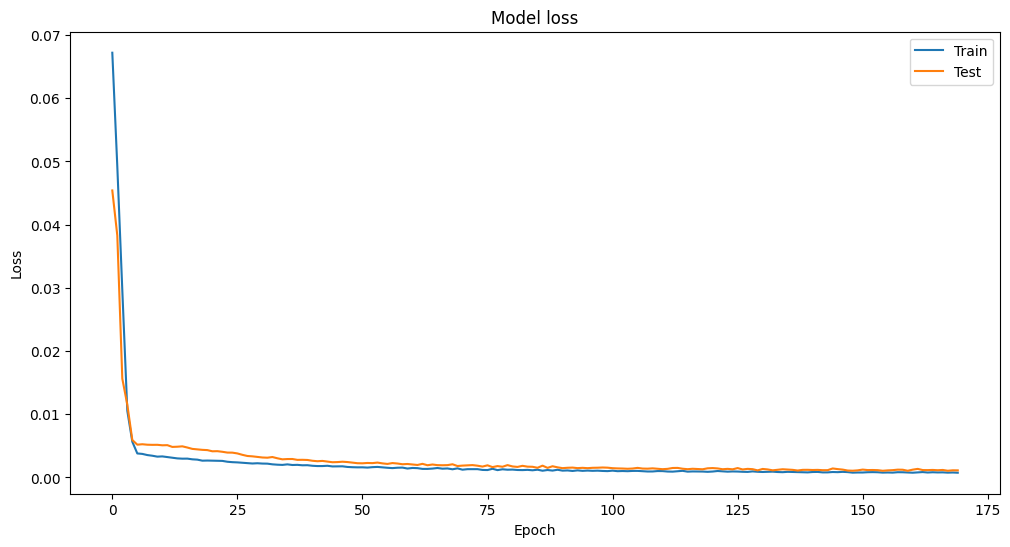

In [37]:
# Visualisasi model Loss dari data uji dan data validasi
from matplotlib import pyplot as plt
plt.figure(figsize=[12,6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [38]:
# Menyimpan model
#saved_model = load_model(os.path.join(OUTPUT_PATH, '/content/drive/My Drive/TA_LSTM/outputs/best_model.h5')) 
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) 
print(saved_model)

In [39]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Nilai Error dari MSE sebesar ", error, y_pred.shape, y_test_t.shape)
print("Harga prediksi esok hari sebelum denormalisasi :",y_pred[0])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] 
print("Harga prediksi esok hari sesudah denormalisasi :",y_pred_org[0])

12/12 [==============================] - 1s 6ms/step
Nilai Error dari MSE sebesar  0.0003490534434199523 (240,) (240,)
Harga prediksi esok hari sebelum denormalisasi : 0.34672254
Harga prediksi esok hari sesudah denormalisasi : 1290.1489


# Visualisasi hasil prediksi



In [40]:
kurang = y_pred_org - y_test_t_org
kurang_table = pd.DataFrame(kurang, columns=['hasil pengurangan uji dgn validasi'])
kurang_table.to_csv (r'/content/drive/My Drive/TA_LSTM/outputs/Hasil pengurangan ep200 8020.csv', index = None, header=True)

Program selesai pada  5.0 menit :  58.0 detik


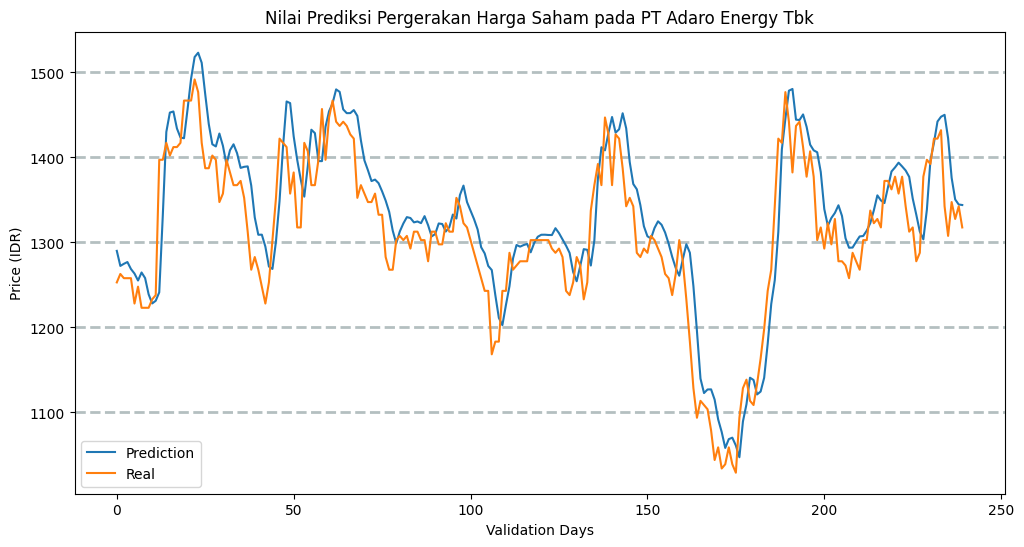

In [41]:
# Visualisasi hasil prediksi dengan model yang sudah dibuat
from matplotlib import pyplot as plt
plt.figure(figsize=[12,6])
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Nilai Prediksi Pergerakan Harga Saham pada PT Adaro Energy Tbk')
plt.ylabel('Price (IDR)')
plt.xlabel('Validation Days')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend(['Prediction', 'Real'], loc='lower left')
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("Program selesai pada ", stime)

# Evaluasi Model yang sudah dibuat

In [42]:
# Evaluasi model
score = model.evaluate(x_t, y_t, batch_size=BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

110/110 [==============================] - 1s 6ms/step - loss: 6.6261e-04 - accuracy: 9.0909e-04
Test loss: 0.00066260906169191
Test accuracy: 0.0009090909152291715


# Menyimpan hasil prediksi ke dalam csv

In [43]:
# Menyimpan hasil data prediksi ke dalam bentuk Dataframe
pred_table = pd.DataFrame(y_pred_org, columns=['Close'])

# Melakukan Ekspor data menjadi bentuk CSV
export_csv = pred_table.to_csv (r'/content/drive/My Drive/TA_LSTM/outputs/Prediksi Close Price.csv', index = None, header=True) 
print ("Dokumen CSV sudah tersimpan di direktori", OUTPUT_PATH)

Dokumen CSV sudah tersimpan di direktori /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes


In [44]:
# Menggabungkan dataset dengan data lama
df_close = df.drop(columns=['Date','Open', 'High', 'Low', 'Adj Close', 'Volume'])
df_new = pd.concat([df_close, pred_table], ignore_index=True, sort=True)

# Menyimpan dataset baru
export_csv = df_new.to_csv(r'/content/drive/My Drive/TA_LSTM/outputs/Dataset baru.csv', index = None, header=True) 
print ("Dokumen CSV sudah tersimpan di direktori", OUTPUT_PATH)

Dokumen CSV sudah tersimpan di direktori /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes


# SEKIAN DARI KAMI
 